# Nonlinear Directional Coherence



In [1]:
import identFunctions as ident
import GFRFfunctions as GFRF
import numpy as np
import matplotlib.pyplot as plt
from sympy.plotting import plot3d, plot
import sympy as sym
from scipy.signal import filtfilt, butter, correlate
import scipy

All of those signals were estimated by computing the Nonlinear Output Frequency Response Function (NOFRF) (Billings, 2013) of the NARMAX identified systems. The systems were identified with the FROLS method (Billings, 2013).

## Example 1

\begin{align}
   u(i) =& 0.5u(i-1) - 0.3u(i-2) + 0.1y(i-2) + 0.4y(i-1)y(i-2) + eu(i-1)\\
   y(i) =& 0.3y(i-1) - y(i-2) - 0.1u(i-2) + ey(i-1)
\end{align}

In [2]:
def system(u, Fs, noiseSTD=0.0, eu=0, ey=0):
    N = len(u)
    t = np.arange(0, N/Fs, 1/Fs)
#    y = np.sin(2*np.pi*4.52*t).reshape(-1,1)
    y = 0*np.random.randn(len(u), 1)
    
    for i in range(2, len(u)):
        u[i] = 0.5*u[i-1] - 0.3*u[i-2] + 0.1*y[i-2] + 0.4*y[i-1]*y[i-2] + eu[i-1]
        y[i] = 0.3*y[i-1] - y[i-2] - 0.1*u[i-2] + ey[i-1]

    u = u + noiseSTD*np.random.randn(N, 1)
    y = y + noiseSTD*np.random.randn(N, 1)
    
    return t, u, y

In [4]:
Fs = 20.0
N = 100000

u = 0*np.random.randn(N, 1)
eu = 0.2*np.random.randn(N, 1)
ey = 0.2*np.random.randn(N, 1)

#ey = filtfilt(b, a, ey, axis = 0)
#eu = filtfilt(b, a, eu, axis = 0)

t, u, y = system(u, Fs, noiseSTD=0, eu=eu, ey=ey)

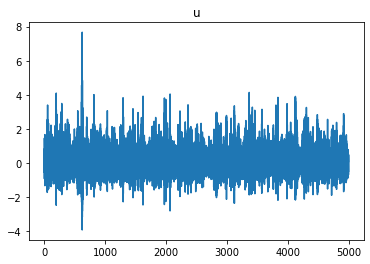

In [5]:
plt.figure()
plt.plot(t, u)
plt.title('u')
plt.show()

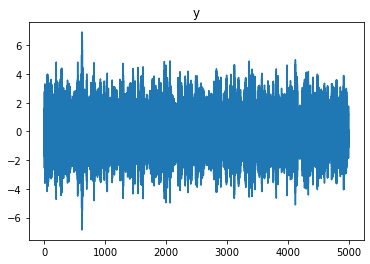

In [6]:
plt.figure()
plt.plot(t, y)
plt.title('y')
plt.show()

### Signals FFT

signals FFTs


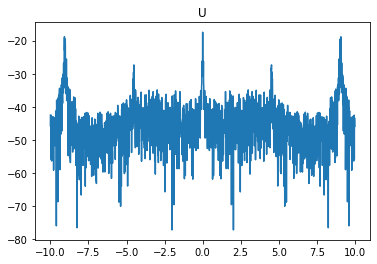

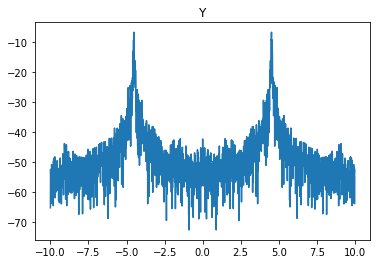

In [7]:
fmin = 0
fmax = Fs/2
fres = 0.01
#%%
print('signals FFTs')
Y, f = GFRF.computeSignalFFT(ident.reshapeyvector(y, L=1), Fs, fres)
U, f = GFRF.computeSignalFFT(ident.reshapeyvector(u, L=1), Fs, fres)
EU, f = GFRF.computeSignalFFT(ident.reshapeyvector(eu, L=1), Fs, fres)

plt.figure()
plt.plot(f, 20*np.log10(np.abs(U)))
plt.title('U')
plt.show()

plt.figure()
plt.plot(f, 20*np.log10(np.abs(Y)))
plt.title('Y')
plt.show()

### System identification

In [8]:
maxLagu = 2
maxLagy = 2
order = 2
u.shape

(100000, 1)

#### $u \rightarrow y$

In [10]:
%time beta_uy, n_uy, Duy = ident.identifyModel(u, y, maxLagu, maxLagy, ustring='u', ystring='y', nstring='n', delay=1, degree=order, L=20, constantTerm=True, pho = 0.005, supress=True)





u(i-2) -0.1006653055537838
y(i-1) 0.300217553785902
y(i-2) -0.9995281602785033


CPU times: user 6.35 s, sys: 295 ms, total: 6.65 s
Wall time: 4.72 s


#### $y \rightarrow u$

In [11]:
beta_yu, n_yu, Dyu = ident.identifyModel(y, u, maxLagy, maxLagu, ustring='y',
                                         ystring='u', nstring='m', delay=1,
                                         degree=2, L=20, constantTerm=True,
                                         pho=0.01, supress=True)





y(i-2) 0.10027107653543636
u(i-1) 0.49889037266717706
u(i-2) -0.29744701770199933
y(i-1)y(i-2) 0.3997967964314608
y(i-1)u(i-2) 0.0005943438617264221




### Generalised Frequency Responses

#### $u \rightarrow y$

In [ ]:
Hnuy = GFRF.computeSystemGFRF(Duy, Fs, beta_uy, order, ustring='u', ystring='y')
Hnuy[1]

In [ ]:
Hnuy[2]

#### $y \rightarrow u$

In [ ]:
Hnyu = GFRF.computeSystemGFRF(Dyu, Fs, beta_yu, order, ustring='y', ystring='u')
Hnyu[1]

In [ ]:
Hnyu[2]

### Transfer of Power between the signals

\begin{equation}
    I_{U\rightarrow Y} = \ln\frac{\left|Y_{u_l^-,y_l^-,u_n^-,y_n^-} \right|^2 + \left|Y_{y_l^-,y_n^-} \right|^2}{\left|Y_{y_l^-,y_n^-} \right|^2}
\end{equation}

\begin{equation}
    I_{Y\rightarrow U} = \ln\frac{\left|U_{u_l^-,y_l^-,u_n^-,y_n^-} \right|^2 + \left|U_{u_l^-,u_n^-}\right|^2}{\left|U_{u_l^-,u_n^-} \right|^2}
\end{equation}

\begin{equation}
    I_{U\rightarrow U} = \ln\frac{\left|U_{u_l^-,y_l^-,u_n^-,y_n^-}  \right|^2 + \left|U_{u_l^-,u_n^-} \right|^2}{\left|U_{u_l^-,y_l^-,u_n^-,y_n^-} \right|^2}
\end{equation}

\begin{equation}
    I_{Y\rightarrow Y} = \ln\frac{\left|Y_{u_l^-,y_l^-,u_n^-,y_n^-}  \right|^2 + \left|Y_{y_l^-,y_n^-} \right|^2}{\left|Y_{u_l^-,y_l^-,u_n^-,y_n^-} \right|^2}
\end{equation}


where $Y_{u_l^-,y_l^-,u_n^-,y_n^-}$ is the part of $y$ caused by the past of the signals $u$ and $y$, $U_{u_l^-,y_l^-,u_n^-,y_n^-}$ is the part of $u$ caused by the past of the signals $u$ and $y$, $Y_{y_l^-,y_n^-}$ is the intrinsic part of $y$ caused by the past of the signals $y$ and the error model $e_y$ and $U_{u_l^-,u_n^-}$ is the intrinsic part of $u$ caused by the past of the signals $u$ and the error model $e_u$. 

### Coherence 1 (Normalized Power Transfer)

\begin{equation}
    NC_{U\rightarrow Y} = \frac{I_{U \rightarrow Y}}{\sqrt{I_{U \rightarrow Y}^2+I_{Y \rightarrow Y}^2+I_{U \rightarrow U}^2+I_{Y \rightarrow U}^2}}
\end{equation}

\begin{equation}
    NC_{Y\rightarrow U} = \frac{I_{Y \rightarrow U}}{\sqrt{I_{U \rightarrow Y}^2+I_{Y \rightarrow Y}^2+I_{U \rightarrow U}^2+I_{Y \rightarrow U}^2}}
\end{equation}

In [ ]:
f_inputMin = 0
f_inputMax = Fs/2
maxDegree = 2
NPDCuy, NPDCyu, f, NPDCuyn, NPDCyun, NPDCuyLinear, NPDCyuLinear, NPDCuynLinear, NPDCyunLinear = GFRF.NPDC(u, y, Fs, fres, beta_uy, beta_yu, Duy, Dyu,
                                                                                                          Hnuy, Hnyu, f_inputMin, f_inputMax, maxOrder=maxDegree, 
                                                                                                          L=50, ustring='u', ystring='y')
    
        

In [ ]:
plt.figure()
# plt.plot(f, np.abs(NPDCuyn))
plt.plot(f, np.abs(NPDCuy))
# plt.plot(f, np.abs(np.mean(NPDCuyn, axis=1)), linewidth=6)
plt.ylim(0, 1)
plt.title('NPDC u->y')
plt.show()


plt.figure()
# plt.plot(f, np.abs(NPDCyun))
plt.plot(f, np.abs(NPDCyu))
plt.ylim(0, 1)
plt.title('NPDC y->u')
plt.show()



                                                                                         
plt.figure()
# plt.plot(f, np.abs(NPDCuynLinear))
plt.plot(f, np.abs(NPDCuyLinear))
plt.ylim(0, 1)
plt.title('NPDC u->y Linear')
plt.show()


plt.figure()
# plt.plot(f, np.abs(NPDCyunLinear))
plt.plot(f, np.abs(NPDCyuLinear))
plt.ylim(0, 1)
plt.title('NPDC y->u Linear')
plt.show()

## Example 2

\begin{align}
   u(i) =& 0.5u(i-1) - 0.3u(i-2) + 0.1y(i-2) + 0.4y(i-1)y(i-2) + eu(i-1)\\
   y(i) =& \sin\left(2\pi4.2\frac{i}{F_s}\right) + ey(i-1)
\end{align}

with $F_s=20$ Hz.

In [ ]:
def system2(u, Fs, noiseSTD=0.0, eu=0, ey=0):
    N = len(u)
    t = np.arange(0, N/Fs, 1/Fs)
#     y = np.sin(2*np.pi*4.52*t).reshape(-1,1)
    y = 0*np.random.randn(len(u), 1)
    
    for i in range(2, len(u)):
        u[i] = 0.5*u[i-1] - 0.3*u[i-2] + 0.1*y[i-2] + 0.4*y[i-1]*y[i-2] + eu[i-1]
        y[i] = 5*np.sin(2*np.pi*4.5*t[i]) + ey[i-1]

    u = u + noiseSTD*np.random.randn(N, 1)
    y = y + noiseSTD*np.random.randn(N, 1)
    
    return t, u, y

In [ ]:
Fs = 20.0
N = 100000

u = 0*np.random.randn(N, 1)
eu = 0.2*np.random.randn(N, 1)
ey = 0.1*np.random.randn(N, 1)

#ey = filtfilt(b, a, ey, axis = 0)
#eu = filtfilt(b, a, eu, axis = 0)

t, u, y = system2(u, Fs, noiseSTD=0, eu=eu, ey=ey)

In [ ]:
plt.figure()
plt.plot(t, u)
plt.title('u')
plt.show()

In [ ]:
plt.figure()
plt.plot(t, y)
plt.title('y')
plt.show()

### Signals FFT

In [ ]:
fmin = 0
fmax = Fs/2
fres = 0.01
#%%
print('signals FFTs')
Y, f = GFRF.computeSignalFFT(ident.reshapeyvector(y, L=1), Fs, fres)
U, f = GFRF.computeSignalFFT(ident.reshapeyvector(u, L=1), Fs, fres)
EU, f = GFRF.computeSignalFFT(ident.reshapeyvector(eu, L=1), Fs, fres)

plt.figure()
plt.plot(f, 20*np.log10(np.abs(U)))
plt.title('U')
plt.show()

plt.figure()
plt.plot(f, 20*np.log10(np.abs(Y)))
plt.title('Y')
plt.show()

### System identification

In [ ]:
maxLagu = 5
maxLagy = 5
order = 2


#### $u \rightarrow y$

In [ ]:
beta_uy, n_uy, Duy = ident.identifyModel(u, y, maxLagu, maxLagy, ustring='u',
                                         ystring='y', nstring='n', delay=1,
                                         degree=order, L=20, constantTerm=True,
                                         pho = 0.0001, supress=False)

#### $y \rightarrow u$

In [ ]:
beta_yu, n_yu, Dyu = ident.identifyModel(y, u, maxLagy, maxLagu, ustring='y',
                                         ystring='u', nstring='m', delay=1,
                                         degree=2, L=20, constantTerm=True,
                                         pho=0.0001, supress=False)

In [ ]:
_, n_uy, maxLag_uy = ident.osaWithStruct(u, y, beta_uy, Duy, 2, 
                                         ustring='u', ystring='y')
n_uy

In [ ]:
_, n_yu, maxLag_yu = ident.osaWithStruct(y, u, beta_yu, Dyu, 2, 
                                         ustring='y', ystring='u')
n_yu

### Generalised Frequency Responses

#### $u \rightarrow y$

In [ ]:
Hnuy = GFRF.computeSystemGFRF(Duy, Fs, beta_uy, order, ustring='u', ystring='y')
Hnuy[1]

In [ ]:
Hnuy[2]

#### $y \rightarrow u$

In [ ]:
Hnyu = GFRF.computeSystemGFRF(Dyu, Fs, beta_yu, order, ustring='y', ystring='u')
Hnyu[1]

In [ ]:
Hnyu[2]

In [ ]:
f1, f2 = sym.symbols('f1 f2')
Hu = sym.lambdify(f1, Hnyu[1], 'numpy')

fV = np.linspace(-Fs/2, Fs/2, 100000)


plt.figure()
plt.plot(fV, np.abs(Hu(fV)))
plt.title('Hu1')
plt.show()


plot3d(sym.Abs(Hnyu[2]), (f1,-Fs/2, Fs/2), (f2,-Fs/2, Fs/2))


### Transfer of Power between the signals

### Coherence (Normalized Power Transfer)

\begin{equation}
    NC_{U\rightarrow Y} = \frac{I_{U \rightarrow Y}}{\sqrt{I_{U \rightarrow Y}^2+I_{Y \rightarrow Y}^2+I_{U \rightarrow U}^2+I_{Y \rightarrow U}^2}}
\end{equation}

\begin{equation}
    NC_{Y\rightarrow U} = \frac{I_{Y \rightarrow U}}{\sqrt{I_{U \rightarrow Y}^2+I_{Y \rightarrow Y}^2+I_{U \rightarrow U}^2+I_{Y \rightarrow U}^2}}
\end{equation}

In [ ]:
f_inputMin = 0
f_inputMax = Fs/2
maxDegree = 2
NPDCuy, NPDCyu, f, NPDCuyn, NPDCyun, NPDCuyLinear, NPDCyuLinear, NPDCuynLinear, NPDCyunLinear = GFRF.NPDC(u, y, Fs, fres, beta_uy, beta_yu, Duy, Dyu,
                                                                                                          Hnuy, Hnyu, f_inputMin, f_inputMax, maxOrder=maxDegree, 
                                                                                                          N=50, ustring='u', ystring='y')
    

In [ ]:
plt.figure()
# plt.plot(f, np.abs(NPDCuyn))
plt.plot(f, np.abs(NPDCuy))
# plt.plot(f, np.abs(np.mean(NPDCuyn, axis=1)), linewidth=6)
plt.ylim(0, 1)
plt.title('NPDC u->y')
plt.show()


plt.figure()
plt.plot(f, np.abs(NPDCyun))
plt.plot(f, np.abs(NPDCyu), linewidth=5)
plt.ylim(0, 1)
plt.title('NPDC y->u')
plt.show()



                                                                                         
plt.figure()
# plt.plot(f, np.abs(NPDCuynLinear))
plt.plot(f, np.abs(NPDCuyLinear))
plt.ylim(0, 1)
plt.title('NPDC u->y Linear')
plt.show()


plt.figure()
# plt.plot(f, np.abs(NPDCyunLinear))
plt.plot(f, np.abs(NPDCyuLinear))
plt.ylim(0, 1)
plt.title('NPDC y->u Linear')
plt.show()

## Example 3

\begin{align}
    y(i) = & \sin(2\pi2i) + \sin(2\pi3i) +e_y(i-1)\\
    u(i) = & 0.5u(i-1) - 0.3u(i-2) +0.1y(i-2) + 0.1u(i-2)^2 +0.4y(i-1)y(i-2) + e_y(i-1)
\end{align}

In [ ]:
def system3(u, Fs, noiseSTD=0.0, eu=0, ey=0):
    N = len(u)
    t = np.arange(0, N/Fs, 1/Fs)
#     y = np.sin(2*np.pi*4.52*t).reshape(-1,1)
    y = 0*np.random.randn(len(u), 1)
    
    for i in range(2, len(u)):
        y[i] = np.sin(2*np.pi*2*t[i]) + np.sin(2*np.pi*3*t[i]) + ey[i-1]
        u[i] = 0.5*u[i-1] - 0.3*u[i-2] + 0.1*y[i-2] + 0.1*u[i-2]**2 + 0.4*y[i-1]*y[i-2] + eu[i-1]

    u = u + noiseSTD*np.random.randn(N, 1)
    y = y + noiseSTD*np.random.randn(N, 1)
    
    return t, u, y

In [ ]:
Fs = 20.0
N = 600

u = 0*np.random.randn(N, 1)
eu = 0.05*np.random.randn(N, 1)
ey = 0.02*np.random.randn(N, 1)

#ey = filtfilt(b, a, ey, axis = 0)
#eu = filtfilt(b, a, eu, axis = 0)

t, u, y = system3(u, Fs, noiseSTD=0, eu=eu, ey=ey)

In [ ]:
plt.figure()
plt.plot(t, u)
plt.title('u')
plt.show()

In [ ]:
plt.figure()
plt.plot(t, y)
plt.title('y')
plt.show()

### Signals FFT

In [ ]:
fmin = 0
fmax = Fs/2
fres = 0.01
#%%
print('signals FFTs')
Y, f = GFRF.computeSignalFFT(ident.reshapeyvector(y, L=1), Fs, fres)
U, f = GFRF.computeSignalFFT(ident.reshapeyvector(u, L=1), Fs, fres)
EU, f = GFRF.computeSignalFFT(ident.reshapeyvector(eu, L=1), Fs, fres)

plt.figure()
plt.plot(f, 20*np.log10(np.abs(U)))
plt.title('U')
plt.show()

plt.figure()
plt.plot(f, 20*np.log10(np.abs(Y)))
plt.title('Y')
plt.show()

### System identification

In [ ]:
maxLagu = 2
maxLagy = 2
order = 2


#### $u \rightarrow y$

In [ ]:
beta_uy, n_uy, Duy = ident.identifyModel(u, y, maxLagu, maxLagy, ustring='u',
                                         ystring='y', nstring='n', delay=1,
                                         degree=order, L=1, constantTerm=True,
                                         pho = 0.0005, supress=False)

#### $y \rightarrow u$

In [ ]:
beta_yu, n_yu, Dyu = ident.identifyModel(y, u, maxLagy, maxLagu, ustring='y',
                                         ystring='u', nstring='m', delay=1,
                                         degree=2, L=10, constantTerm=True,
                                         pho=0.0001, supress=False)

### Generalised Frequency Responses

#### $u \rightarrow y$

In [ ]:
Hnuy = GFRF.computeSystemGFRF(Duy, Fs, beta_uy, order, ustring='u', ystring='y')
Hnuy[1]

In [ ]:
Hnuy[2]

#### $y \rightarrow u$

In [ ]:
Hnyu = GFRF.computeSystemGFRF(Dyu, Fs, beta_yu, order, ustring='y', ystring='u')
Hnyu[1]

In [ ]:
Hnyu[2]

### Transfer of Power between the signals

\begin{equation}
    I_{U\rightarrow Y} = \ln\frac{\left|Y_{u_l^-,y_l^-,u_n^-,y_n^-} \right|^2 + \left|Y_{y_l^-,y_n^-} \right|^2}{\left|Y_{y_l^-,y_n^-} \right|^2}
\end{equation}

\begin{equation}
    I_{Y\rightarrow U} = \ln\frac{\left|U_{u_l^-,y_l^-,u_n^-,y_n^-} \right|^2 + \left|U_{u_l^-,u_n^-}\right|^2}{\left|U_{u_l^-,u_n^-} \right|^2}
\end{equation}

\begin{equation}
    I_{U\rightarrow U} = \ln\frac{\left|U_{u_l^-,y_l^-,u_n^-,y_n^-}  \right|^2 + \left|U_{u_l^-,u_n^-} \right|^2}{\left|U_{u_l^-,y_l^-,u_n^-,y_n^-} \right|^2}
\end{equation}

\begin{equation}
    I_{Y\rightarrow Y} = \ln\frac{\left|Y_{u_l^-,y_l^-,u_n^-,y_n^-}  \right|^2 + \left|Y_{y_l^-,y_n^-} \right|^2}{\left|Y_{u_l^-,y_l^-,u_n^-,y_n^-} \right|^2}
\end{equation}


where $Y_{u_l^-,y_l^-,u_n^-,y_n^-}$ is the part of $y$ caused by the past of the signals $u$ and $y$, $U_{u_l^-,y_l^-,u_n^-,y_n^-}$ is the part of $u$ caused by the past of the signals $u$ and $y$, $Y_{y_l^-,y_n^-}$ is the intrinsic part of $y$ caused by the past of the signals $y$ and the error model $e_y$ and $U_{u_l^-,u_n^-}$ is the intrinsic part of $u$ caused by the past of the signals $u$ and the error model $e_u$. 

### Coherence 1 (Normalized Power Transfer)

\begin{equation}
    NC_{U\rightarrow Y} = \frac{I_{U \rightarrow Y}}{\sqrt{I_{U \rightarrow Y}^2+I_{Y \rightarrow Y}^2+I_{U \rightarrow U}^2+I_{Y \rightarrow U}^2}}
\end{equation}

\begin{equation}
    NC_{Y\rightarrow U} = \frac{I_{Y \rightarrow U}}{\sqrt{I_{U \rightarrow Y}^2+I_{Y \rightarrow Y}^2+I_{U \rightarrow U}^2+I_{Y \rightarrow U}^2}}
\end{equation}

In [ ]:
f_inputMin = 0
f_inputMax = Fs/2
maxDegree = 2
NPDCuy, NPDCyu, f, NPDCuyn, NPDCyun, NPDCuyLinear, NPDCyuLinear, NPDCuynLinear, NPDCyunLinear = GFRF.NPDC(u, y, Fs, fres, beta_uy, beta_yu, Duy, Dyu,
                                                                                                          Hnuy, Hnyu, f_inputMin, f_inputMax, maxOrder=maxDegree, 
                                                                                                          N=50, ustring='u', ystring='y')
    

In [ ]:
plt.figure()
# plt.plot(f, np.abs(NPDCuyn))
plt.plot(f, np.abs(NPDCuy))
# plt.plot(f, np.abs(np.mean(NPDCuyn, axis=1)), linewidth=6)
plt.ylim(0, 1)
plt.title('NPDC u->y')
plt.show()


plt.figure()
# plt.plot(f, np.abs(NPDCyun))
plt.plot(f, np.abs(NPDCyu))
plt.ylim(0, 1)
plt.title('NPDC y->u')
plt.show()



                                                                                         
plt.figure()
# plt.plot(f, np.abs(NPDCuynLinear))
plt.plot(f, np.abs(NPDCuyLinear))
plt.ylim(0, 1)
plt.title('NPDC u->y Linear')
plt.show()


plt.figure()
# plt.plot(f, np.abs(NPDCyunLinear))
plt.plot(f, np.abs(NPDCyuLinear))
plt.ylim(0, 1)
plt.title('NPDC y->u Linear')
plt.show()

## Example 4

\begin{align}
   u(i) = & 0.5u(i-1) - 0.3u(i-2) +0.1y(i-2) + 0.1u(i-2)^2 +0.4y(i-1)y(i-2) + e_u(i-1)\\
   y(i) =& 0.3y(i-1) - y(i-2) - 0.1u(i-2) + ey(i-1)\\   
\end{align}

In [ ]:
def system4(u, Fs, noiseSTD=0.0, eu=0, ey=0):
    N = len(u)
    t = np.arange(0, N/Fs, 1/Fs)
#    y = np.sin(2*np.pi*4.52*t).reshape(-1,1)
    y = 0*np.random.randn(len(u), 1)
    
    for i in range(2, len(u)):
        u[i] = 0.5*u[i-1] - 0.3*u[i-2] + 0.1*y[i-2] + 0.1*u[i-2]**2 + 0.4*y[i-1]*y[i-2] + eu[i-1]
        y[i] = 0.3*y[i-1] - y[i-2] - 0.1*u[i-2] + ey[i-1]

    u = u + noiseSTD*np.random.randn(N, 1)
    y = y + noiseSTD*np.random.randn(N, 1)
    
    return t, u, y

In [ ]:
Fs = 20.0
N = 100000

u = 0*np.random.randn(N, 1)
eu = 0.1*np.random.randn(N, 1)
ey = 0.1*np.random.randn(N, 1)

#ey = filtfilt(b, a, ey, axis = 0)
#eu = filtfilt(b, a, eu, axis = 0)

t, u, y = system4(u, Fs, noiseSTD=0, eu=eu, ey=ey)

In [ ]:
plt.figure()
plt.plot(t, u)
plt.title('u')
plt.show()

In [ ]:
plt.figure()
plt.plot(t, y)
plt.title('y')
plt.show()

### Signals FFT

In [ ]:
fmin = 0
fmax = Fs/2
fres = 0.01
#%%
print('signals FFTs')
Y, f = GFRF.computeSignalFFT(ident.reshapeyvector(y, L=1), Fs, fres)
U, f = GFRF.computeSignalFFT(ident.reshapeyvector(u, L=1), Fs, fres)
EU, f = GFRF.computeSignalFFT(ident.reshapeyvector(eu, L=1), Fs, fres)

plt.figure()
plt.plot(f, 20*np.log10(np.abs(U)))
plt.title('U')
plt.show()

plt.figure()
plt.plot(f, 20*np.log10(np.abs(Y)))
plt.title('Y')
plt.show()

### System identification

In [ ]:
maxLagu = 2
maxLagy = 2
order = 2


#### $u \rightarrow y$

In [ ]:
beta_uy, n_uy, Duy = ident.identifyModel(u, y, maxLagu, maxLagy, ustring='u',
                                         ystring='y', nstring='n', delay=1,
                                         degree=order, L=20, constantTerm=True,
                                         pho = 0.005, supress=False)

#### $y \rightarrow u$

In [ ]:
beta_yu, n_yu, Dyu = ident.identifyModel(y, u, maxLagy, maxLagu, ustring='y',
                                         ystring='u', nstring='m', delay=1,
                                         degree=2, L=20, constantTerm=True,
                                         pho=0.0001, supress=False)

### Generalised Frequency Responses

#### $u \rightarrow y$

In [ ]:
Hnuy = GFRF.computeSystemGFRF(Duy, Fs, beta_uy, order, ustring='u', ystring='y')
Hnuy[1]

In [ ]:
Hnuy[2]

#### $y \rightarrow u$

In [ ]:
Hnyu = GFRF.computeSystemGFRF(Dyu, Fs, beta_yu, order, ustring='y', ystring='u')
Hnyu[1]

In [ ]:
Hnyu[2]

### Transfer of Power between the signals

\begin{equation}
    I_{U\rightarrow Y} = \ln\frac{\left|Y_{u_l^-,y_l^-,u_n^-,y_n^-} \right|^2 + \left|Y_{y_l^-,y_n^-} \right|^2}{\left|Y_{y_l^-,y_n^-} \right|^2}
\end{equation}

\begin{equation}
    I_{Y\rightarrow U} = \ln\frac{\left|U_{u_l^-,y_l^-,u_n^-,y_n^-} \right|^2 + \left|U_{u_l^-,u_n^-}\right|^2}{\left|U_{u_l^-,u_n^-} \right|^2}
\end{equation}

\begin{equation}
    I_{U\rightarrow U} = \ln\frac{\left|U_{u_l^-,y_l^-,u_n^-,y_n^-}  \right|^2 + \left|U_{u_l^-,u_n^-} \right|^2}{\left|U_{u_l^-,y_l^-,u_n^-,y_n^-} \right|^2}
\end{equation}

\begin{equation}
    I_{Y\rightarrow Y} = \ln\frac{\left|Y_{u_l^-,y_l^-,u_n^-,y_n^-}  \right|^2 + \left|Y_{y_l^-,y_n^-} \right|^2}{\left|Y_{u_l^-,y_l^-,u_n^-,y_n^-} \right|^2}
\end{equation}


where $Y_{u_l^-,y_l^-,u_n^-,y_n^-}$ is the part of $y$ caused by the past of the signals $u$ and $y$, $U_{u_l^-,y_l^-,u_n^-,y_n^-}$ is the part of $u$ caused by the past of the signals $u$ and $y$, $Y_{y_l^-,y_n^-}$ is the intrinsic part of $y$ caused by the past of the signals $y$ and the error model $e_y$ and $U_{u_l^-,u_n^-}$ is the intrinsic part of $u$ caused by the past of the signals $u$ and the error model $e_u$. 

### Coherence (Normalized Power Transfer)

\begin{equation}
    NC_{U\rightarrow Y} = \frac{I_{U \rightarrow Y}}{\sqrt{I_{U \rightarrow Y}^2+I_{Y \rightarrow Y}^2+I_{U \rightarrow U}^2+I_{Y \rightarrow U}^2}}
\end{equation}

\begin{equation}
    NC_{Y\rightarrow U} = \frac{I_{Y \rightarrow U}}{\sqrt{I_{U \rightarrow Y}^2+I_{Y \rightarrow Y}^2+I_{U \rightarrow U}^2+I_{Y \rightarrow U}^2}}
\end{equation}

In [ ]:
L = 50
NPDCuy, NPDCyu, f, NPDCuyn, NPDCyun, NPDCuyLinear, NPDCyuLinear, NPDCuynLinear, NPDCyunLinear = GFRF.NPDC(u, y, Fs, fres, beta_uy, beta_yu, Duy, Dyu,
                                                                                                          Hnuy, Hnyu, f_inputMin, f_inputMax, maxOrder=maxDegree, 
                                                                                                          N=L, ustring='u', ystring='y')
    


Th = 1 - (1-0.95)**(1/(L-1))

In [ ]:
plt.figure()
# plt.plot(f, np.abs(NPDCuyn))
plt.plot(f, np.abs(NPDCuy))
plt.plot(f, Th*np.ones_like(f), '--k')
# plt.plot(f, np.abs(np.mean(NPDCuyn, axis=1)), linewidth=6)
plt.ylim(0, 1)
plt.title('NPDC u->y')
plt.show()


plt.figure()
# plt.plot(f, np.abs(NPDCyun))
plt.plot(f, np.abs(NPDCyu))
plt.plot(f, Th*np.ones_like(f), '--k')
plt.ylim(0, 1)
plt.title('NPDC y->u')
plt.show()



                                                                                         
plt.figure()
# plt.plot(f, np.abs(NPDCuynLinear))
plt.plot(f, np.abs(NPDCuyLinear))
plt.plot(f, Th*np.ones_like(f), '--k')
plt.ylim(0, 1)
plt.title('NPDC u->y Linear')
plt.show()


plt.figure()
# plt.plot(f, np.abs(NPDCyunLinear))
plt.plot(f, np.abs(NPDCyuLinear))
plt.plot(f, Th*np.ones_like(f), '--k')
plt.ylim(0, 1)
plt.title('NPDC y->u Linear')
plt.show()

## Example 5

\begin{align}
   u(i) = &  e_u(i-1)\\
   y(i) =& e_y(i-1)\\   
\end{align}

In [ ]:
def system5(u, Fs, noiseSTD=0.0, eu=0, ey=0):
    N = len(u)
    t = np.arange(0, N/Fs, 1/Fs)
#    y = np.sin(2*np.pi*4.52*t).reshape(-1,1)
    y = 0*np.random.randn(len(u), 1)
    
    for i in range(0, len(u)):
        u[i] = eu[i]
        y[i] = ey[i]

    u = u + noiseSTD*np.random.randn(N, 1)
    y = y + noiseSTD*np.random.randn(N, 1)
    
    return t, u, y

In [ ]:
Fs = 20.0
N = 100000

u = 0*np.random.randn(N, 1)
eu = 0.1*np.random.randn(N, 1)
ey = 0.1*np.random.randn(N, 1)

#ey = filtfilt(b, a, ey, axis = 0)
#eu = filtfilt(b, a, eu, axis = 0)

t, u, y = system5(u, Fs, noiseSTD=0, eu=eu, ey=ey)

In [ ]:
plt.figure()
plt.plot(t, u)
plt.title('u')
plt.show()

In [ ]:
plt.figure()
plt.plot(t, y)
plt.title('y')
plt.show()

### Signals FFT

In [ ]:
fmin = 0
fmax = Fs/2
fres = 0.01
#%%
print('signals FFTs')
Y, f = GFRF.computeSignalFFT(ident.reshapeyvector(y, L=1), Fs, fres)
U, f = GFRF.computeSignalFFT(ident.reshapeyvector(u, L=1), Fs, fres)
EU, f = GFRF.computeSignalFFT(ident.reshapeyvector(eu, L=1), Fs, fres)

plt.figure()
plt.plot(f, 20*np.log10(np.abs(U)))
plt.title('U')
plt.show()

plt.figure()
plt.plot(f, 20*np.log10(np.abs(Y)))
plt.title('Y')
plt.show()

### System identification

In [ ]:
maxLagu = 2
maxLagy = 2
order = 2


#### $u \rightarrow y$

In [ ]:
beta_uy, n_uy, Duy = ident.identifyModel(u, y, maxLagu, maxLagy, ustring='u',
                                         ystring='y', nstring='n', delay=1,
                                         degree=order, L=200, constantTerm=True,
                                         pho = 0.0001, supress=False)

#### $y \rightarrow u$

In [ ]:
beta_yu, n_yu, Dyu = ident.identifyModel(y, u, maxLagy, maxLagu, ustring='y',
                                         ystring='u', nstring='m', delay=1,
                                         degree=2, L=200, constantTerm=True,
                                         pho=0.0001, supress=False)

### Generalised Frequency Responses

#### $u \rightarrow y$

In [ ]:
Hnuy = GFRF.computeSystemGFRF(Duy, Fs, beta_uy, order, ustring='u', ystring='y')
Hnuy[1]

In [ ]:
Hnuy[2]

#### $y \rightarrow u$

In [ ]:
Hnyu = GFRF.computeSystemGFRF(Dyu, Fs, beta_yu, order, ustring='y', ystring='u')
Hnyu[1]

In [ ]:
Hnyu[2]

### Transfer of Power between the signals

\begin{equation}
    I_{U\rightarrow Y} = \ln\frac{\left|Y_{u_l^-,y_l^-,u_n^-,y_n^-} \right|^2 + \left|Y_{y_l^-,y_n^-} \right|^2}{\left|Y_{y_l^-,y_n^-} \right|^2}
\end{equation}

\begin{equation}
    I_{Y\rightarrow U} = \ln\frac{\left|U_{u_l^-,y_l^-,u_n^-,y_n^-} \right|^2 + \left|U_{u_l^-,u_n^-}\right|^2}{\left|U_{u_l^-,u_n^-} \right|^2}
\end{equation}

\begin{equation}
    I_{U\rightarrow U} = \ln\frac{\left|U_{u_l^-,y_l^-,u_n^-,y_n^-}  \right|^2 + \left|U_{u_l^-,u_n^-} \right|^2}{\left|U_{u_l^-,y_l^-,u_n^-,y_n^-} \right|^2}
\end{equation}

\begin{equation}
    I_{Y\rightarrow Y} = \ln\frac{\left|Y_{u_l^-,y_l^-,u_n^-,y_n^-}  \right|^2 + \left|Y_{y_l^-,y_n^-} \right|^2}{\left|Y_{u_l^-,y_l^-,u_n^-,y_n^-} \right|^2}
\end{equation}


where $Y_{u_l^-,y_l^-,u_n^-,y_n^-}$ is the part of $y$ caused by the past of the signals $u$ and $y$, $U_{u_l^-,y_l^-,u_n^-,y_n^-}$ is the part of $u$ caused by the past of the signals $u$ and $y$, $Y_{y_l^-,y_n^-}$ is the intrinsic part of $y$ caused by the past of the signals $y$ and the error model $e_y$ and $U_{u_l^-,u_n^-}$ is the intrinsic part of $u$ caused by the past of the signals $u$ and the error model $e_u$. 

### Coherence 1 (Normalized Power Transfer)

\begin{equation}
    NC_{U\rightarrow Y} = \frac{I_{U \rightarrow Y}}{\sqrt{I_{U \rightarrow Y}^2+I_{Y \rightarrow Y}^2+I_{U \rightarrow U}^2+I_{Y \rightarrow U}^2}}
\end{equation}

\begin{equation}
    NC_{Y\rightarrow U} = \frac{I_{Y \rightarrow U}}{\sqrt{I_{U \rightarrow Y}^2+I_{Y \rightarrow Y}^2+I_{U \rightarrow U}^2+I_{Y \rightarrow U}^2}}
\end{equation}

In [ ]:
NPDCuy, NPDCyu, f, NPDCuyn, NPDCyun, NPDCuyLinear, NPDCyuLinear, NPDCuynLinear, NPDCyunLinear = GFRF.NPDC(u, y, Fs, fres, beta_uy, beta_yu, Duy, Dyu,
                                                                                                          Hnuy, Hnyu, f_inputMin, f_inputMax, maxOrder=maxDegree, 
                                                                                                          N=50, ustring='u', ystring='y')
    

In [ ]:
plt.figure()
plt.plot(f, np.abs(NPDCuyn))
plt.plot(f, np.abs(NPDCuy))
# plt.plot(f, np.abs(np.mean(NPDCuyn, axis=1)), linewidth=6)
plt.ylim(0, 1)
plt.title('NPDC u->y')
plt.show()

plt.figure()
plt.plot(f, np.abs(NPDCyun))
plt.plot(f, np.abs(NPDCyu))
plt.ylim(0, 1)
plt.title('NPDC y->u')
plt.show()
                                                                                       
plt.figure()
# plt.plot(f, np.abs(NPDCuynLinear))
plt.plot(f, np.abs(NPDCuyLinear))
plt.ylim(0, 1)
plt.title('NPDC u->y Linear')
plt.show()

plt.figure()
plt.plot(f, np.abs(NPDCyunLinear))
plt.plot(f, np.abs(NPDCyuLinear))
plt.ylim(0, 1)
plt.title('NPDC y->u Linear')
plt.show()

In [ ]:
L = 1
Th = (np.log((np.abs(np.mean(Y)/L)**2)/(np.abs(1e-7)**2))/
      np.sqrt(2*np.log((np.abs(np.mean(Y)/L)**2)/(np.abs(1e-7)**2))**2 +
              + 2*np.log((np.abs(np.mean(Y)/L)**2)/(np.abs(np.mean(Y)/L+1e-7)**2))**2))

Th

In [ ]:
1/np.sqrt(2)